## **MINI-PROJET 1 :** Prédiction du risque d'abandon scolaire

### **Consignes**

1. **Prétraitement des données :** gérer les variables catégorielles, vérifier les valeurs manquantes, explorer la distribution des variables.


2. **Exploration des corrélations** et visualisation des données (PCA ?).


3. **Choix d’un ou plusieurs modèles de classification** parmi ceux étudiés (KNN, arbre de décision, régression logistique, KMeans).


4. **Évaluation des performances :** utilisez accuracy, recall, precision, f1-score et matrice de confusion.


5. **Recherche des meilleurs hyperparamètres** avec GridSearch et validation croisée.


6. **Analyse critique des résultats :**
- Quels modèles fonctionnent le mieux ? Pourquoi ?
- Quelles sont les limites du modèle ? Des données ?
- Quelle interprétation peut-on faire des métriques obtenues ?
- Que signifie une bonne ou mauvaise précision dans ce contexte ?


**Attention : la partie interprétation comptera pour 50% de la note finale.** Il ne s’agit pas uniquement d’écrire du code mais de démontrer votre compréhension du problème.

### **1. Prétraitement des données**

In [74]:
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer

data_df = pandas.read_csv("Dataset_Abandon_Scolaire.csv")

data_df

,Age,Sexe,Taux_presence,Nombre_retards,Note_moyenne,Situation_familiale,Abandon
0,21,Femme,89.585023,2,15.826896,Enfants à charge,0
1,20,Homme,70.713068,3,12.829358,Célibataire,0
2,22,Femme,82.122963,1,13.086319,Enfants à charge,0
3,24,Homme,87.408859,3,14.992032,Célibataire,0
4,20,Homme,86.470676,3,12.671649,Marié,0
...,...,...,...,...,...,...,...
1995,23,Femme,81.800974,3,12.496245,Marié,0
1996,20,Homme,84.082873,4,13.125663,Célibataire,0
1997,19,Femme,87.114146,1,13.841282,Célibataire,0
1998,20,Femme,83.799064,3,12.061256,Célibataire,0


Gestion des variables catégorielles :

In [47]:
problem = data_df.drop("Abandon", axis=1)
target = data_df["Abandon"]

categorial_features = ["Sexe", "Situation_familiale"]
numeric_features = ["Age", "Taux_presence", "Nombre_retards", "Note_moyenne"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorial_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

problem_transformed = preprocessor.fit_transform(data_df)

encoded_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorial_features)
all_columns = list(encoded_columns) + numeric_features + ["Abandon"]

transformed_df = pandas.DataFrame(problem_transformed.toarray() if hasattr(problem_transformed, 'toarray') else problem_transformed, columns=all_columns)


Normalisation standard des données

In [72]:
standard_scaler_object = StandardScaler()
normalized_problem = standard_scaler_object.fit_transform(problem_transformed)

Vérification des valeurs manquantes :

In [49]:
data_df.apply(lambda x: x=="?", axis=0).sum()

Age                    0
Sexe                   0
Taux_presence          0
Nombre_retards         0
Note_moyenne           0
Situation_familiale    0
Abandon                0
dtype: int64

Il n'y a pas de valeurs manquantes dans le jeu de données.

Nombre de personnes en situation d'abandon scolaire :

In [50]:
data_df[["Abandon"]].value_counts()

Abandon
0          1832
1           168
Name: count, dtype: int64

On remarque que sur 2000 personnes, 168 (soit 8,4%) sont en situation d'abandon scolaire.

### **2. Exploration des corrélations**

Matrice de corrélation :

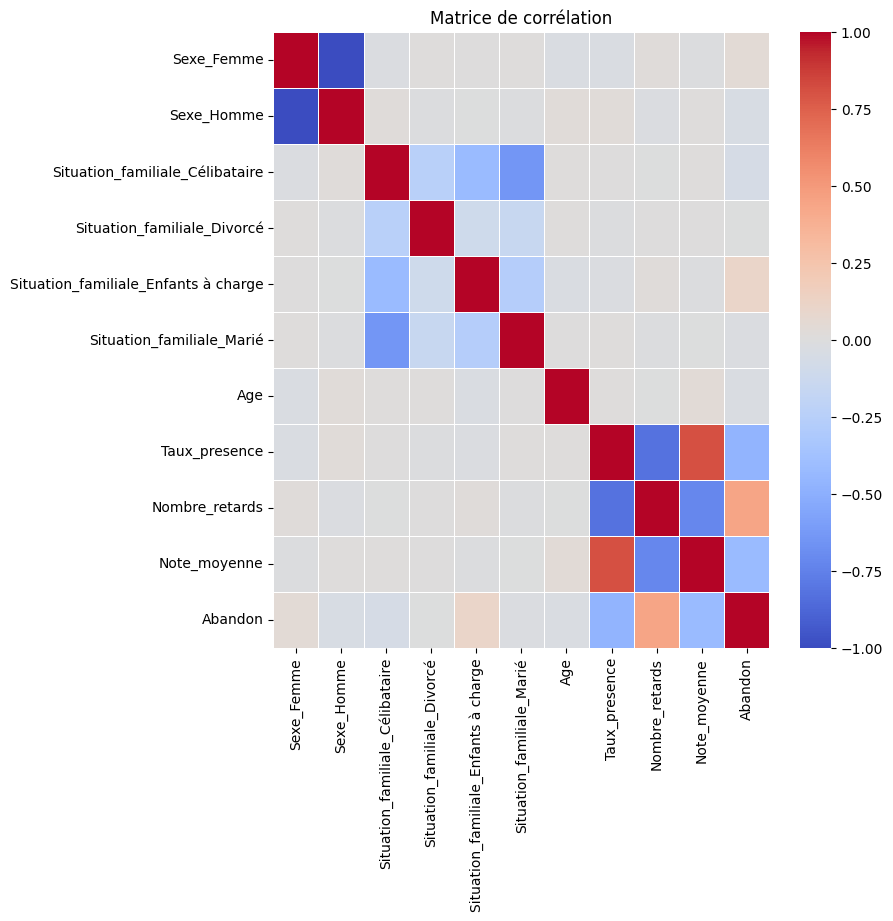

In [51]:
corr_matrix = transformed_df.corr()
plt.figure(figsize=(8, 8))
seaborn.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de corrélation")
plt.show()

Ici nous pouvons observer plusieurs corrélations positives entre différents champs :
- Plus la note moyenne est élevée, plus le taux de présence est élevé
- Plus le nombre de retards est élevé, plus le risque d'abandon scolaire augmente

À l'inverse on observe plusieurs corrélations négatives :
- Plus le nombre de retards est élevé, plus le taux de présence est faible
- Plus la nombre de retards est élevé, plus la note moyenne est basse
- Plus le taux de présence est élevé, plus le riques d'abandon scolaire diminue
- Plus la note moyenne est élevée, plus le risque d'abandon scolaire est faible

PCA (analyse en composantes principales) :

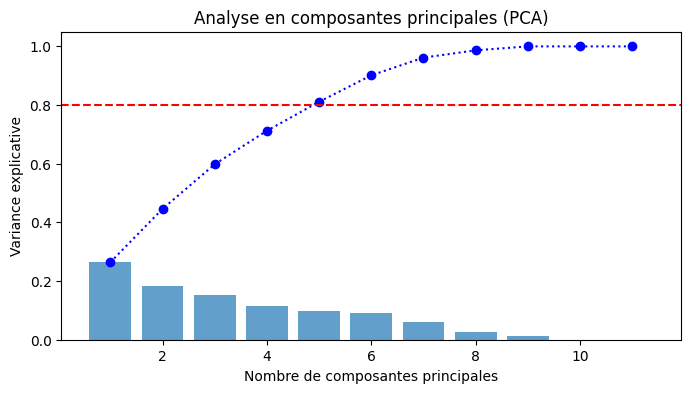

In [67]:
pca_object = PCA()
principal_components_problem = pca_object.fit_transform(normalized_problem)

explained_variance = pca_object.explained_variance_ratio_
cumulative_variance = numpy.cumsum(explained_variance)

plt.figure(figsize=(8,4))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='explained_variance')
plt.plot(range(1, len(cumulative_variance) +1), cumulative_variance, "bo:", label='cumulative_variance')
plt.axhline(y=0.8, color="red", linestyle="--", label="80% d'information utile")
plt.title("Analyse en composantes principales (PCA)")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance explicative")
plt.show()

D'après le graphe ci-dessus, on remarque que les 5 premières composantes principales (PC1 à PC5) cumulées capturent 80% des informations utiles. Autrement dit, nous pouvons réduire la dimension du jeu de données à 5 variables en minimisant la perte d'information.

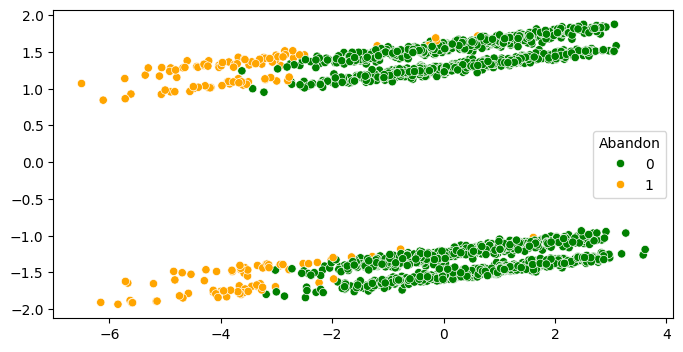

In [68]:
plt.figure(figsize=(8, 4))
custom_palette = {0 : "green", 1:"orange"}
seaborn.scatterplot(x=principal_components_problem[:, 0], y=principal_components_problem[:,1], hue=target, palette=custom_palette)
plt.show()

### **3. Choix d'un ou plusieurs modèles de classification**

Arbre de décision :

In [84]:
def get_optimal_parameters_decision_tree(problem, target):
    n_folds = 5
    parameters = {"classifier__max_depth" : numpy.arange(1, 13),
                  "classifier__min_samples_leaf" : numpy.arange(15, 75, 15),
                  "classifier__criterion" : ["gini", "entropy"]}
    grid_search_object = GridSearchCV(pipeline, 
                                      parameters,
                                      cv=n_folds,
                                      scoring="f1",
                                      verbose=True)
    grid_search_object.fit(problem, target)
    print(grid_search_object.best_params_)
    scores = pandas.DataFrame(grid_search_object.cv_results_)
    best_model = grid_search_object.best_estimator_
    return best_model, scores

best_model, scores = get_optimal_parameters_decision_tree(problem, target)

scores

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'classifier__criterion': 'entropy', 'classifier__max_depth': np.int64(1), 'classifier__min_samples_leaf': np.int64(15)}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.056259,0.027167,0.054860,0.042192,gini,1,15,"{'classifier__criterion': 'gini', 'classifier_...",0.615385,0.696970,0.658228,0.794872,0.746667,0.702424,0.063345,5
1,0.063238,0.029679,0.030704,0.011015,gini,1,30,"{'classifier__criterion': 'gini', 'classifier_...",0.615385,0.696970,0.658228,0.794872,0.746667,0.702424,0.063345,5
2,0.031522,0.008359,0.059725,0.043045,gini,1,45,"{'classifier__criterion': 'gini', 'classifier_...",0.615385,0.696970,0.658228,0.794872,0.746667,0.702424,0.063345,5
3,0.019233,0.005907,0.017899,0.004011,gini,1,60,"{'classifier__criterion': 'gini', 'classifier_...",0.615385,0.696970,0.658228,0.794872,0.746667,0.702424,0.063345,5
4,0.020212,0.012471,0.013481,0.008282,gini,2,15,"{'classifier__criterion': 'gini', 'classifier_...",0.615385,0.696970,0.658228,0.794872,0.746667,0.702424,0.063345,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.018593,0.005189,0.015496,0.005462,entropy,11,60,"{'classifier__criterion': 'entropy', 'classifi...",0.600000,0.520000,0.557377,0.641509,0.620690,0.587915,0.043904,70
92,0.017275,0.003009,0.010796,0.001686,entropy,12,15,"{'classifier__criterion': 'entropy', 'classifi...",0.566667,0.644068,0.584615,0.701754,0.620690,0.623559,0.047533,26
93,0.018404,0.006644,0.015269,0.008185,entropy,12,30,"{'classifier__criterion': 'entropy', 'classifi...",0.611111,0.596491,0.440678,0.576271,0.656250,0.576160,0.072670,85
94,0.021775,0.011381,0.015013,0.005973,entropy,12,45,"{'classifier__criterion': 'entropy', 'classifi...",0.611111,0.625000,0.590164,0.698413,0.767123,0.658362,0.065467,14


### **4. Evaluation des performances**

Classification report : 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       463
           1       0.72      0.84      0.78        37

    accuracy                           0.96       500
   macro avg       0.85      0.91      0.88       500
weighted avg       0.97      0.96      0.97       500



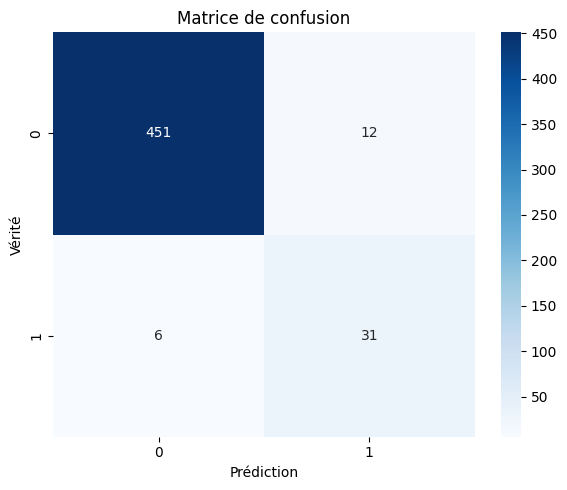

In [86]:
X_train, X_test, y_train, y_test = train_test_split(problem, target, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f'Classification report : \n{classification_report(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.tight_layout()
plt.show()

### **5. Recherche des meilleurs hyperparamètres**

In [85]:
# def get_optimal_k_values(normalized_problem, target):
#     n_folds = 5
#     parameters ={"n_neighbors" : numpy.arange(1, 52)}
#     grid_search_object = GridSearchCV(KNeighborsClassifier(),
#                                       parameters,
#                                       cv=n_folds,
#                                       scoring="f1_macro")
    
#     grid_search_object.fit(normalized_problem, target)
#     print(grid_search_object.best_params_)
#     best_model = grid_search_object.best_estimator_
#     scores = pandas.DataFrame(grid_search_object.cv_results_)
#     return best_model, scores

# scores = get_optimal_k_values(normalized_problem, target)
# scores

### **6. Analyse critique des résultats**

**Quels modèles fonctionnent le mieux ? Pourquoi ?**


**Quelles sont les limites du modèle ? Des données ?**


**Quelle interprétation peut-on faire des métriques obtenues ?**


**Que signifie une bonne ou mauvaise précision dans ce contexte ?**
